# Homework 10 Assignment 2 - Spatial Data Analysis
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [431]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import initial libraries

In [432]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
from fiona.crs import from_epsg
import statsmodels.api as sm
import os 
import sys
import shapely
import pysal as ps
import seaborn as sns
from matplotlib import colors
from geopandas import GeoDataFrame

In [433]:
puidata = os.getenv('HOME') + '/PUIdata'

In [434]:
url_begin = 'https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/'
files = ['ACS_CT2010.csv', 'CitiBike_monthly_byStation.csv', 'Station_id.csv', 'CT_Shape/']
cts = ['ct_shape.shp', 'ct_shape.shx', 'ct_shape.cpg', 'ct_shape.dbf', 'ct_shape.prj', 'R10_BoroCT2010.csv']

In [435]:
for f in files: 
    if f == 'CT_Shape/':
        for ct in cts:
            os.system('curl -O ' + url_begin + f + ct)
            os.system('mv ' + ct + ' ' + puidata)
    else:
        os.system('curl -O ' + url_begin + f)
        os.system('mv ' + f + ' ' + puidata)

## Working with Shape File

### Loading Census Tract Shape File¶

In [436]:
shape_path = puidata + "/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index = ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [437]:
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Census Tract boundaries colored by boroughs

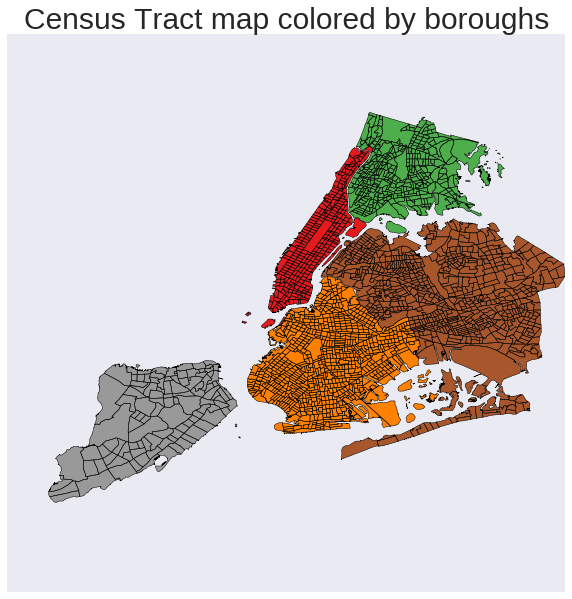

In [438]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
plt.title("Census Tract map colored by boroughs", fontsize = 30)

# Figure 1: Map of NYC showing Census Tracts with colors corresponding to Borough

### Map NYC Population density

#### Load Census Data for 2010

In [439]:
ct_data=DataFrame.from_csv(puidata + '/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [440]:
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Visualize the Population density for 2010

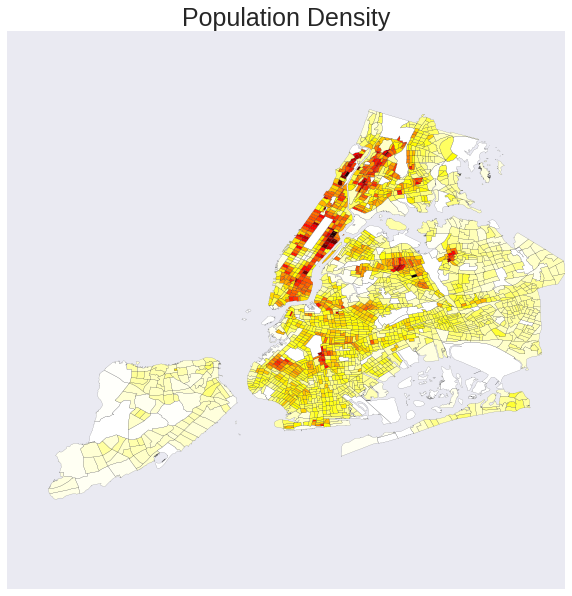

In [441]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density", fontsize = 25)

# Figure 2: Map of NYC Shaded by Population Density

## Explore CitiBike data

### Load CitiBike data

In [442]:
df_bike_monthly=DataFrame.from_csv(puidata + '/CitiBike_monthly_byStation.csv')

### Time Series Analysis

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 10000)

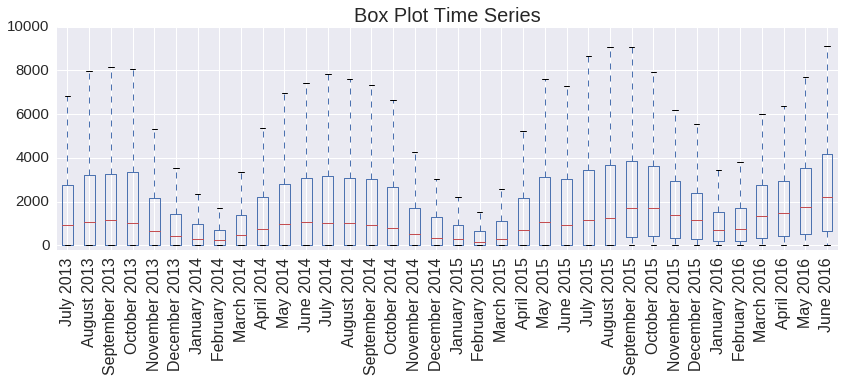

In [443]:
plt.rcParams['font.size']=16
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_monthly_ = df_bike_monthly.copy()
df_bike_monthly_.index=df_bike_monthly.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize=(15,7), ax=ax, rot=90)
plt.title('Box Plot Time Series', fontsize = 20)
ax.set_ylim([-200,10000])

# Figure 3: Box Plots aggregated by Month showing mean and standard deviation for each month of Citibike Data from July 2013 to June 2016

#### Seasonal Decomposition

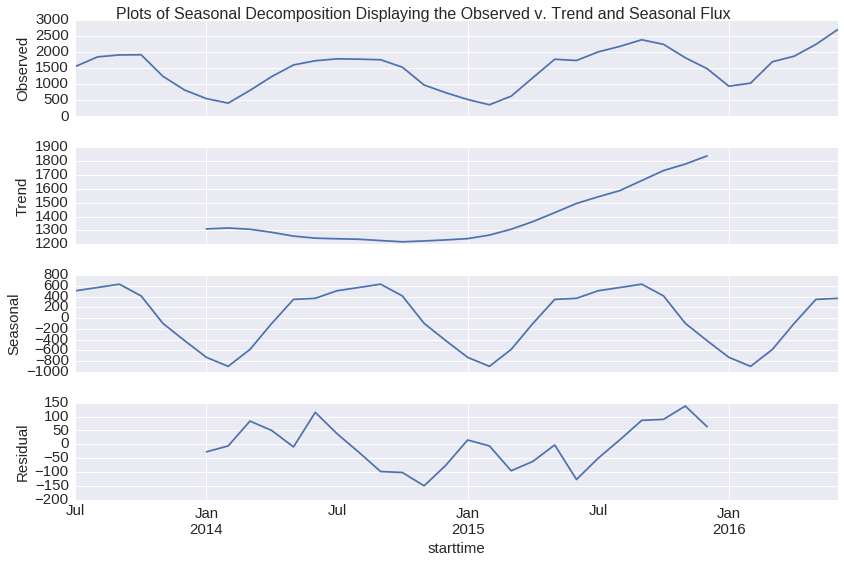

In [444]:
#Create a monthly time series of bike ride (Average of all citibike stations)
df_new=df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize']=(12,8)
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 15

resplot = res.plot()
resplot.suptitle('Plots of Seasonal Decomposition Displaying the Observed v. Trend and Seasonal Flux')

# Figure 4: Seasonal decomposition of the trend v. seasonal fluctuation in Citibike time series data

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [445]:
station_id=DataFrame.from_csv(puidata + '/Station_id.csv')
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Coordinates (Lat & Lon)

In [446]:
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [447]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010']=a

% 100.


In [448]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly rides, dividing into Winter and Summer, to the station GeoDataFrame with CT code

### Define Winter as December - February and Summer as June - August

In [449]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['MonthlyAve']=df_bike_monthly.sum()

df_bike_season = df_bike_monthly
df_bike_season['month'] = df_bike_season.index.strftime('%m')
summer = ['06', '07', '08']
winter = ['12', '01', '02']
summer_df = df_bike_season[df_bike_season.month.isin(summer)]
winter_df = df_bike_season[df_bike_season.month.isin(winter)]
station_id['WinterAve'] = winter_df.sum()
station_id['SummerAve'] = summer_df.sum()

### Add the monthly average rides to the CT shapefile 

In [450]:
# create columns for each seasons average
temp = station_id[['WinterAve', 'SummerAve']]
temp['station_id'] = station_id.index
temp.index = station_id['BoroCT2010']
ct_shape_SeasonalAve = ct_shape.join(temp)
ct_shape_SeasonalAve.fillna(0,inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


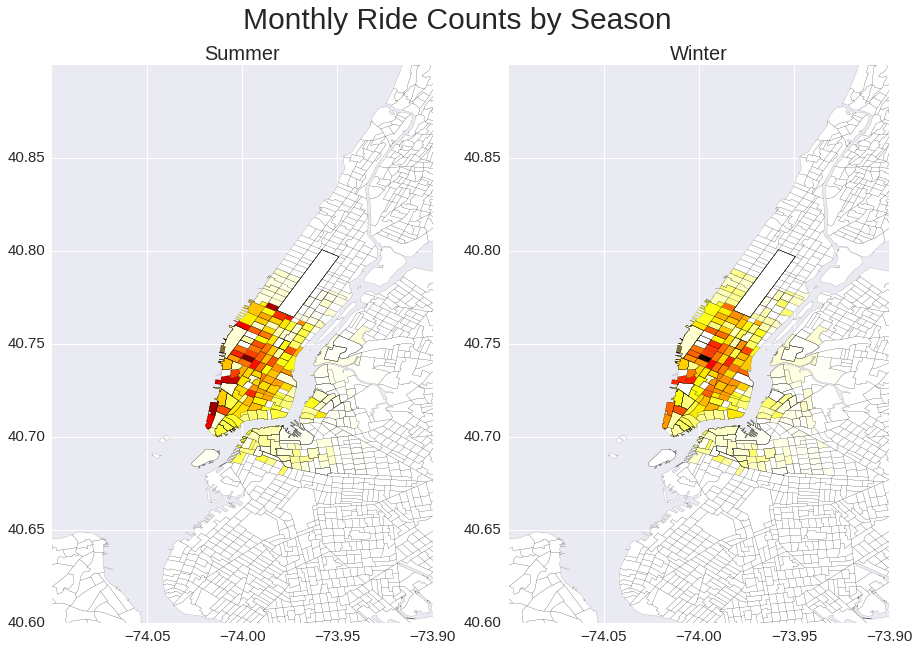

In [451]:
f, ax = plt.subplots(1, 2, figsize=(15,10))
ct_shape_MonthlyAve.plot(column='SummerAve', colormap='hot_r', 
                         alpha=1, linewidth=0.1, ax=ax[0])
ax[0].set_title('Summer', fontsize = 20)
ax[0].set_ylim([40.6, 40.9])
ax[0].set_xlim([-74.1, -73.9])

ct_shape_MonthlyAve.plot(column = 'WinterAve', colormap='hot_r', 
                         alpha=1, linewidth=0.1, ax=ax[1])
ax[1].set_title('Winter', fontsize = 20)
ax[1].set_ylim([40.6, 40.9])
ax[1].set_xlim([-74.1, -73.9])

plt.suptitle("Monthly Ride Counts by Season", fontsize = 30)

# Figure 5: Heatmap of Citibike Ridership separated into seasons where Summer represents the June - Aug and Winter represents December - February

### Removing the CTs that are out of zoom boundries

In [452]:
ct_shape_WS_Zoom=(ct_shape_MonthlyAve[ct_shape_MonthlyAve
                    .centroid.apply(lambda c: c.x >-74.05 and c.x < -73.92 
                    and c.y > 40.67 and c.y < 40.8)])

In [453]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp.SummerAve)
print "Number of zoomed CTs:", len(temp.WinterAve)

Total number of CTs: 2166
Number of zoomed CTs: 543
Number of zoomed CTs: 543


### Map the monthly rides 

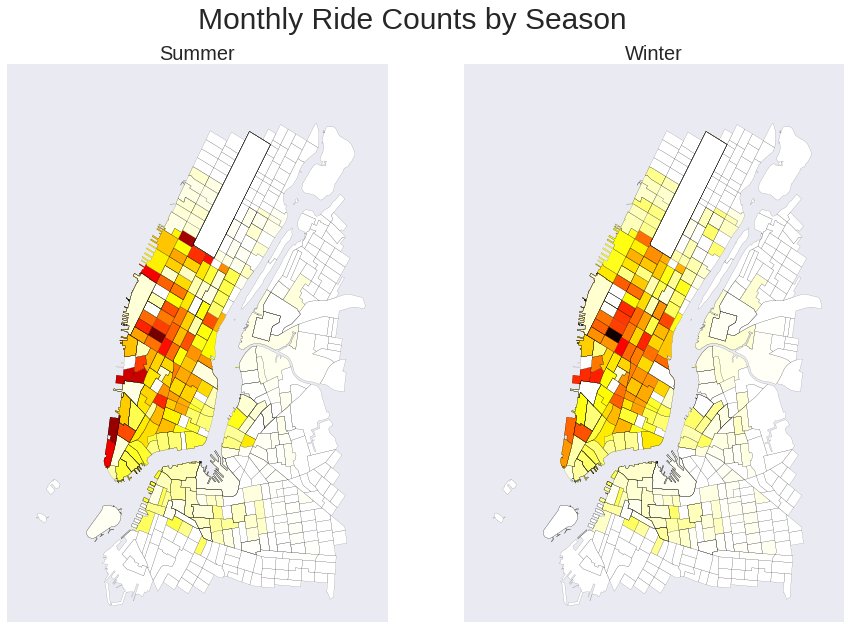

In [454]:
f, ax = plt.subplots(1, 2, figsize=(15,10))
ct_shape_WS_Zoom.plot(column='SummerAve', colormap='hot_r', alpha=1, linewidth=0.1, ax=ax[0])
ax[0].set_title('Summer', fontsize = 20)

ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

ct_shape_WS_Zoom.plot(column = 'WinterAve', colormap='hot_r', alpha=1, linewidth=0.1, ax=ax[1])
ax[1].set_title('Winter', fontsize = 20)

ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
plt.suptitle("Monthly Ride Counts by Season", fontsize = 30)


# Figure 6: Zoomed in Heatmap of Citibike Ridership separated into seasons where Summer represents the June - Aug and Winter represents December - February. It seems that ridership patterns along the west side are different in the summer and winter with the more touristy/pleasurable sections near Chelsea experiencing lower relative ridership in the Winter while the Winter shows higher relative ridership on the upper West and East sides, perhaps reflecting the hard core commuters. 

### Export Shapefile CTs in the CitiBike Zone

In [455]:
path = puidata + '/ct_shape_WS_Zoom.shp'
ct_shape_WS_Zoom.to_file(path)

## Exploratory Geospatial Analysis

### Spatial Weights
Contiguity: Queen Weights

In [456]:
qW_CT = ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [457]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [458]:
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [459]:
Wmatrix, ids = qW_CT.full()

In [460]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [461]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neighbors can be measured by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [462]:
WinterRide = ct_shape_WS_Zoom.WinterAve
WinterRideLag = ps.lag_spatial(qW_CT, WinterRide)
SummerRide = ct_shape_WS_Zoom.SummerAve
SummerRideLag = ps.lag_spatial(qW_CT, SummerRide)

#### Create Quantiles for maping

In [463]:
SummerRideLagQ10 = ps.Quantiles(SummerRideLag, k=10)
WinterRideLagQ10 = ps.Quantiles(WinterRideLag, k=10)
print 'Summer Lag: {}'.format(SummerRideLagQ10)
print 'Winter Lag: {}'.format(WinterRideLagQ10)

Summer Lag:                   Quantiles                   
 
  Lower              Upper               Count
            x[i] <=     0.000               86
    0.000 < x[i] <=   543.524               59
  543.524 < x[i] <=  1661.632               72
 1661.632 < x[i] <=  4308.111               72
 4308.111 < x[i] <=  6383.500               73
 6383.500 < x[i] <= 13170.367               72
13170.367 < x[i] <= 22553.690               72
22553.690 < x[i] <= 28570.297               72
28570.297 < x[i] <= 33026.461               72
33026.461 < x[i] <= 49147.643               73
Winter Lag:                   Quantiles                   
 
  Lower              Upper               Count
            x[i] <=     0.000               86
    0.000 < x[i] <=   412.131               59
  412.131 < x[i] <=  1008.103               72
 1008.103 < x[i] <=  1912.722               72
 1912.722 < x[i] <=  2638.111               73
 2638.111 < x[i] <=  5067.376               72
 5067.376 < x[i] <=  8590.229   

#### Map the monthly rides lag

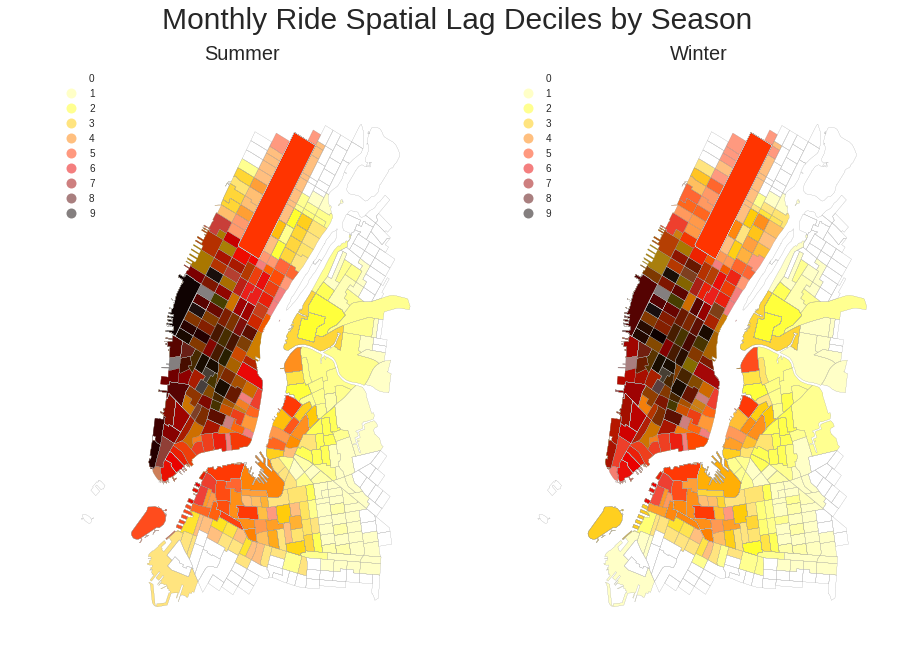

In [464]:
f, ax = plt.subplots(1, 2, figsize=(15,10))


ct_shape_WS_Zoom.plot(column='SummerAve', colormap='hot_r', alpha=1, linewidth=0.1, ax=ax[0])
ax[0].set_title('Summer', fontsize = 20)

ct_shape_WS_Zoom.assign(cl=SummerRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax[0], 
        edgecolor='white', legend=True)
ax[0].set_axis_off()


ct_shape_WS_Zoom.plot(column='WinterAve', colormap='hot_r', alpha=1, linewidth=0.1, ax=ax[1])
ax[1].set_title('Winter', fontsize = 20)

ct_shape_WS_Zoom.assign(cl=WinterRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax[1], 
        edgecolor='white', legend=True)
ax[1].set_axis_off()


plt.suptitle("Monthly Ride Spatial Lag Deciles by Season", fontsize = 30)

# Figure 7: Heat maps of Spatial Lag Deciles per season. The patterns look similar between seasons

## Global  Spatial Autocorrelation

In [465]:
b, a = np.polyfit(WinterRide, WinterRideLag, 1)
print 'Winter Lag slope coefficient is {0} and intercept is {1}'.format(b, a)

Winter Lag slope coefficient is 0.64074346984 and intercept is 1862.90517105


In [466]:
b1, a1 = np.polyfit(SummerRide, SummerRideLag, 1)
print 'Summer Lag slope coefficient is {0} and intercept is {1}'.format(b1, a1)

Summer Lag slope coefficient is 0.62426370945 and intercept is 4894.63638814


### Moran Scatterplot

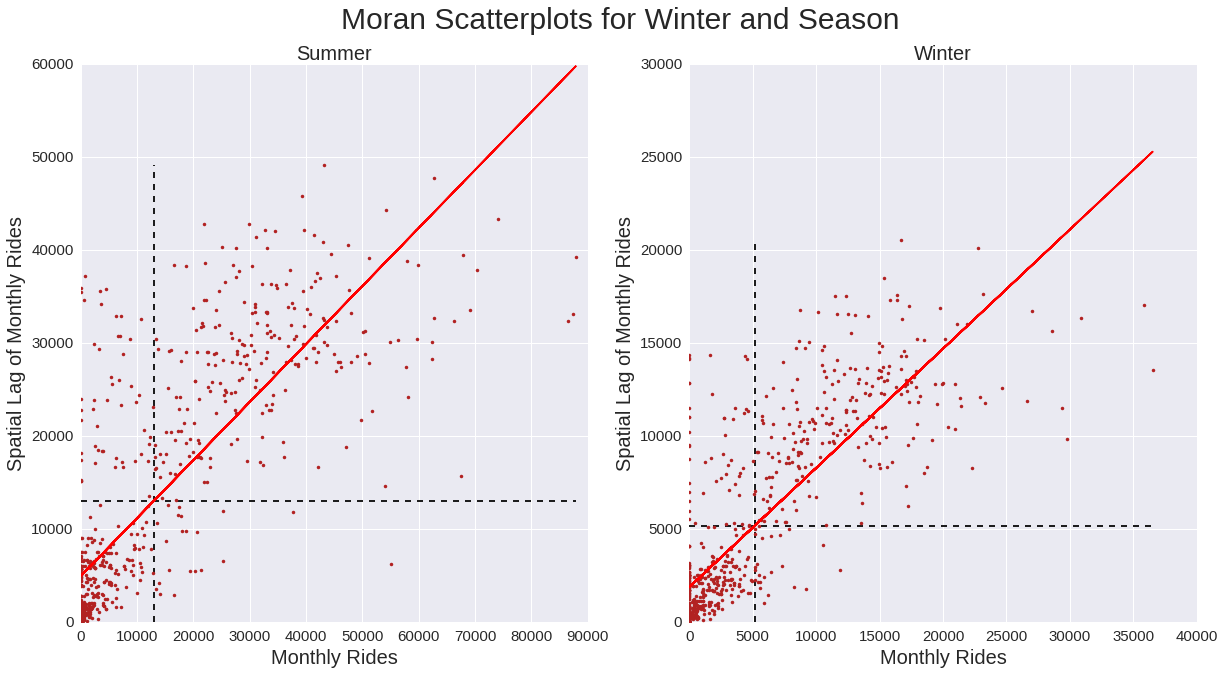

In [467]:
f, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(SummerRide, SummerRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
ax[0].vlines(SummerRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
ax[0].hlines(SummerRideLag.mean(), SummerRide.min(), SummerRide.max(), linestyle='--')

ylims = [0, max(WinterRideLag.max(), SummerRideLag.max())]
xlims = [0, max(WinterRide.max(), SummerRide.max())]
# red line of best fit using global I as slope
ax[0].plot(SummerRide, a1 + b1 * SummerRide, 'r')
ax[0].set_title('Summer', fontsize = 20)
ax[0].set_ylabel('Spatial Lag of Monthly Rides', fontsize = 20)
ax[0].set_xlabel('Monthly Rides', fontsize = 20)


ax[1].plot(WinterRide, WinterRideLag, '.', color = 'firebrick')

 # dashed vert at mean of the last year's PCI
ax[1].vlines(WinterRide.mean(), WinterRideLag.min(), WinterRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
ax[1].hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle='--')

# red line of best fit using global I as slope
ax[1].plot(WinterRide, a + b * WinterRide, 'r')
ax[1].set_title('Winter', fontsize = 20)
ax[1].set_ylabel('Spatial Lag of Monthly Rides', fontsize = 20)
ax[1].set_xlabel('Monthly Rides', fontsize = 20)

plt.suptitle('Moran Scatterplots for Winter and Season', fontsize = 30)

# Figure 8: Plots of Rides v. Spatial Lag for each of the two seasons, Summer and Winter. Winter seems to have more rides in the low-low section of the scatter plot indicating more cold spots than Summer

### Moran's I

In [468]:
I_SummerRide = ps.Moran(SummerRide, qW_CT, permutations = 999)
I_WinterRide = ps.Moran(WinterRide, qW_CT, permutations = 999)

In [469]:
print I_SummerRide.I, I_SummerRide.p_sim
print I_WinterRide.I, I_WinterRide.p_sim

0.624323689148 0.001
0.640770613448 0.001


Thus, the $I$ statistic is $0.624$ for Summer and $0.641$ for Winter. Both have a very small $p$ value. Therefore, we can reject the null hypothesis at the $\alpha = 0.05$ level that there data is not spatially autocorrelated

In [470]:
print I_WinterRide.sim[0:10], I_SummerRide.sim[0:10]

[-0.00732064 -0.00385955 -0.00491426 -0.00276053 -0.02134073  0.01809035
 -0.01562939  0.0126369  -0.00072735 -0.00668297] [-0.01798608  0.0013963   0.02908196 -0.00513362 -0.01136227 -0.01297531
 -0.01224815 -0.02696851  0.00569871  0.02583101]


### KDEplot of all of the simulated points
the vertical line shows the observed value

In [471]:
plt.rcParams['figure.figsize']=(20,8)

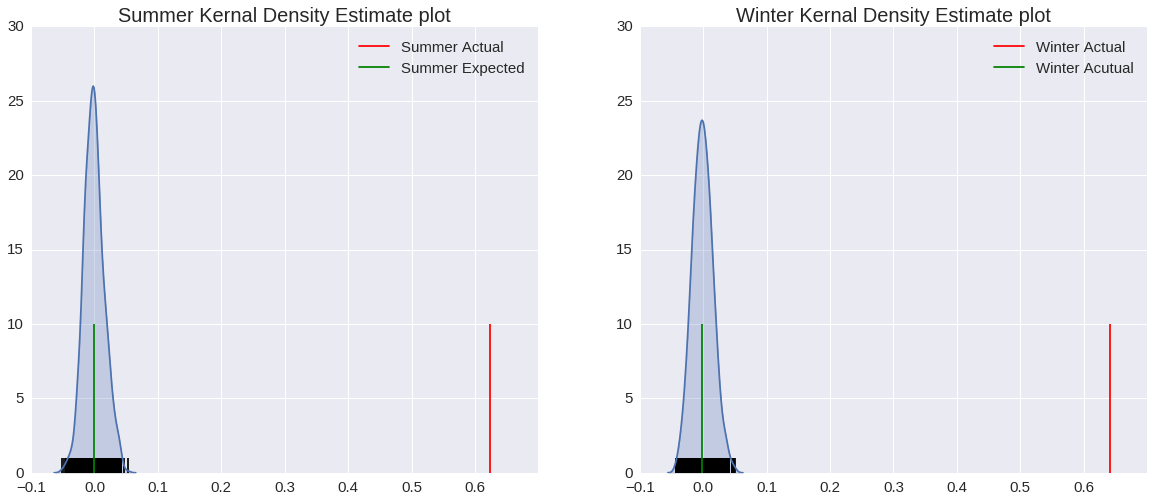

In [472]:
fig, ax = plt.subplots(1, 2)
sns.kdeplot(I_SummerRide.sim, shade=True, ax = ax[0])
ax[0].vlines(I_SummerRide.sim, 0, 1)
ax[0].vlines(I_SummerRide.I, 0, 10, 'r', label = 'Summer Actual')
ax[0].vlines(I_SummerRide.EI, 0, 10, 'g', label = 'Summer Expected')
ax[0].set_xlim([-.1, .70])
ax[0].set_ylim([0, 30])
ax[0].set_title('Summer Kernal Density Estimate plot', fontsize = 20)
ax[0].legend(fontsize = 15)
   
sns.kdeplot(I_WinterRide.sim, shade=True, ax = ax[1])
ax[1].vlines(I_WinterRide.sim, 0, 1)
ax[1].vlines(I_WinterRide.I, 0, 10, 'r', label = 'Winter Actual')
ax[1].vlines(I_WinterRide.EI, 0, 10, 'g', label = 'Winter Acutual')
ax[1].set_xlim([-.1, .70])
ax[1].set_ylim([0, 30])
ax[1].set_title('Winter Kernal Density Estimate plot', fontsize = 20)
ax[1].legend(fontsize = 15)

# Figure 9: Kernal density plots for each season displaying the expected value of the Moran's I compared to the actual value. The expected values are shown in green and the actual values are shown in red. The actual value does not fall within the expected range.

## Local  Spatial Autocorrelation

In [473]:
LMo_SummerRide = ps.Moran_Local(SummerRide, qW_CT,permutations=999)
LMo_WinterRide = ps.Moran_Local(WinterRide, qW_CT,permutations=999)

In [474]:
print LMo_SummerRide.Is[0:5], LMo_SummerRide.p_sim[0:5]
print LMo_WinterRide.Is[0:5], LMo_WinterRide.p_sim[0:5]

[-0.         -0.19863606  0.00180003 -0.00175432  0.00208431] [ 0.001  0.231  0.404  0.418  0.465]
[-0.         -0.27508588  0.01609391 -0.00819051 -0.12949202] [ 0.001  0.163  0.428  0.394  0.304]


### LISA (Local Indicators of Spatial Autocorrelation)

In [475]:
sigs_w = WinterRide[LMo_WinterRide.p_sim <= .001]
W_sigs_w = WinterRideLag[LMo_WinterRide.p_sim <= .001]
insigs_w = WinterRide[LMo_WinterRide.p_sim > .001]
W_insigs_w = WinterRideLag[LMo_WinterRide.p_sim > .001]

sigs_s = SummerRide[LMo_SummerRide.p_sim <= .001]
W_sigs_s = SummerRideLag[LMo_SummerRide.p_sim <= .001]
insigs_s = SummerRide[LMo_SummerRide.p_sim > .001]
W_insigs_s = SummerRideLag[LMo_SummerRide.p_sim > .001]

### Plot Signficant LISA

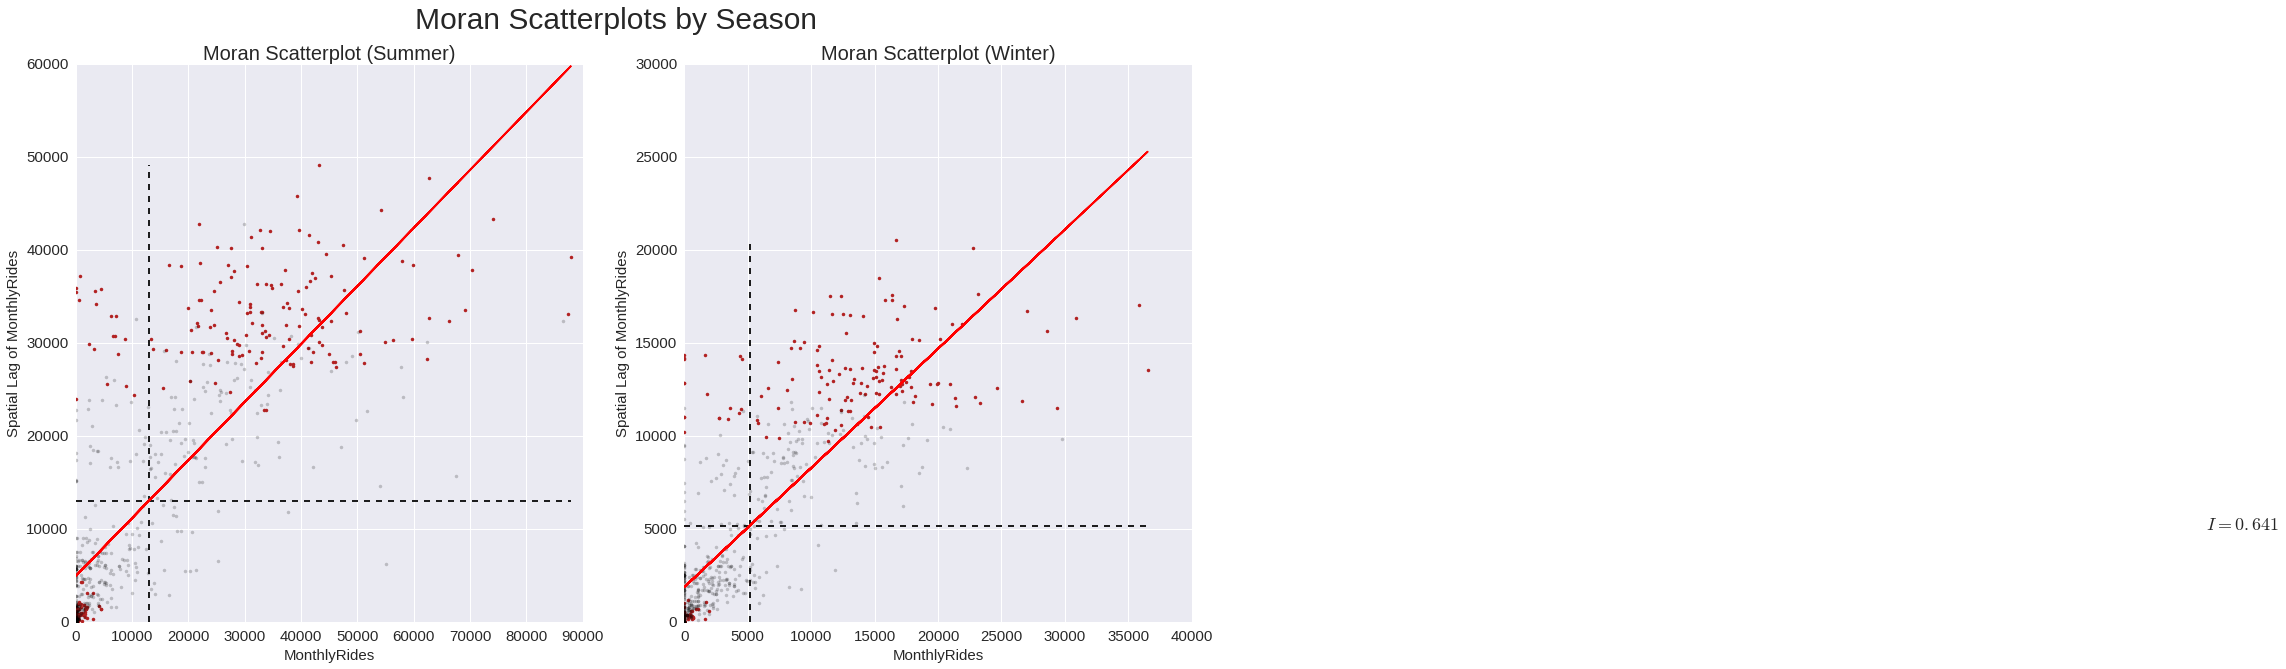

In [476]:
f, ax = plt.subplots(1, 2, figsize = (20, 10))

ax[0].plot(sigs_s, W_sigs_s, '.', color='firebrick')
ax[0].plot(insigs_s, W_insigs_s, '.k', alpha=.2)
ax[0].text(s='$I = %.3f$' % I_SummerRide.I, x=120000, y=5000, fontsize=18)

ax[0].vlines(SummerRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle='--')
ax[0].hlines(SummerRideLag.mean(), SummerRide.min(), SummerRide.max(), linestyle='--')
ax[0].plot(SummerRide, a1 + b1 * SummerRide, 'r')
ax[0].set_title('Moran Scatterplot (Summer)', fontsize = 20)
ax[0].set_ylabel('Spatial Lag of MonthlyRides', fontsize = 15)
ax[0].set_xlabel('MonthlyRides', fontsize = 15)

ax[1].plot(sigs_w, W_sigs_w, '.', color='firebrick')
ax[1].plot(insigs_w, W_insigs_w, '.k', alpha=.2)
ax[1].text(s='$I = %.3f$' % I_WinterRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
ax[1].vlines(WinterRide.mean(), WinterRideLag.min(),WinterRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
ax[1].hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle='--')

# red line of best fit using global I as slope
ax[1].plot(WinterRide, a + b * WinterRide, 'r')
ax[1].set_title('Moran Scatterplot (Winter)', fontsize = 20)
ax[1].set_ylabel('Spatial Lag of MonthlyRides', fontsize = 15)
ax[1].set_xlabel('MonthlyRides', fontsize = 15)

plt.suptitle('Moran Scatterplots by Season', fontsize = 30)


# Figure 10: Moran Scatter Plots by season where those local points with p-values significant at the 0.001 level are colored red and those that aren't are colored black

### Hot and Cold spots 

In [477]:
sig_w = LMo_WinterRide.p_sim < 0.01
hotspots_w = LMo_WinterRide.q==1 * sig_w
coldspots_w = LMo_WinterRide.q==3 * sig_w

sig_s = LMo_SummerRide.p_sim < 0.01
hotspots_s = LMo_SummerRide.q==1 * sig_s
coldspots_s = LMo_SummerRide.q==3 * sig_s

print "Number of Hotspots (Summer):", hotspots_s.sum()
print "Number of Coldspots (Summer):", coldspots_s.sum()
print "Number of Hotspots (Winter):", hotspots_w.sum()
print "Number of Coldspots (Winter):", coldspots_w.sum()

Number of Hotspots (Summer): 183
Number of Coldspots (Summer): 231
Number of Hotspots (Winter): 171
Number of Coldspots (Winter): 243


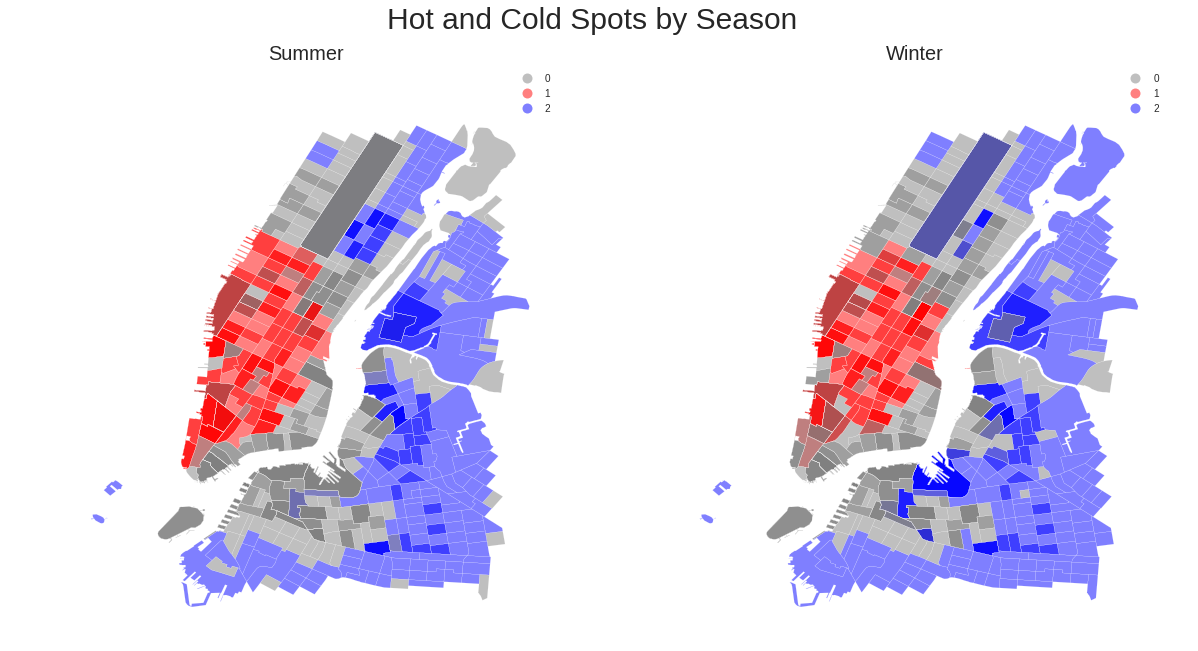

In [478]:
hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold_w = hotspots_w * 1 + coldspots_w * 2
hotcold_s = hotspots_s * 1 + coldspots_s * 2

f, ax = plt.subplots(1, 2, figsize=(20, 10))

ct_shape_WS_Zoom.assign(cl = hotcold_s).plot(column = 'cl', categorical = True, 
        k = 10, cmap = hcmap, linewidth = 0.1, ax = ax[0], 
        edgecolor = 'white', legend = True)

ct_shape_WS_Zoom.assign(cl=hotcold_w).plot(column='cl', categorical = True, 
        k = 10, cmap = hcmap, linewidth = 0.1, ax = ax[1], 
        edgecolor = 'white', legend = True)
ax[0].set_title('Summer', fontsize = 20)
ax[1].set_title('Winter', fontsize = 20)
ax[0].set_axis_off()
ax[1].set_axis_off()
plt.suptitle("Hot and Cold Spots by Season", fontsize = 30)

# Figure 11: Maps of hot and cold spots of Citibike data as separated by season. For the most part, they display the same patterns, but there are more cold spots/neutral spots in the Winter map especially along the waterfront in Brooklyn and the West Side greenway in Manhattan. This might be due to a decrease in recreational riders as the weather gets colder. 